# Gather IFS forecast files from WeatherBench 2

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
# ------------------------------------------------- #
# interpolation utils
# from scipy.interpolate import griddata
import scipy.interpolate as spint
from scipy.spatial import Delaunay
import itertools

def interp_weights(xy, uv, d=2):
    tri = Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [3]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu

In [4]:
config_name = os.path.realpath('verif_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [5]:
model_name = 'IFS'
filename_prefix = 'IFS_%Y-%m-%dT%HZ.nc'
save_loc = conf[model_name]['save_loc'] + filename_prefix

In [6]:
verif_ind_start = 1000; verif_ind_end = 4500

In [7]:
# interpolation weights were computed for 90N -> 90S
# IFS is 90S -> 90N, should be flipped
flip_lat = True 

In [8]:
# import original IFS from WeatherBench GS
ds_IFS = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr')

# --------------------------------------------------------- #
# subset and organize their xr.Dataset

variables_levels = conf[model_name]['verif_variables']
ds_IFS = vu.ds_subset_everything(ds_IFS, variables_levels)

# unify variable and coord names
ds_IFS = ds_IFS.rename({'latitude':'lat','longitude':'lon'})
ds_IFS = ds_IFS.rename(conf[model_name]['rename_variables'])
ds_IFS = ds_IFS.squeeze('level')
ds_IFS = ds_IFS.isel(prediction_timedelta=slice(1, 42)) # <--- IFS lead time begins at 0, we drop 0

In [9]:
# # get our lat/lons on regular Gaussian grid
# OURS_dataset = xr.open_dataset(conf['geo']['geo_file_nc'])
# x_OURS = np.array(OURS_dataset['longitude'])
# y_OURS = np.array(OURS_dataset['latitude'])
# lon_OURS, lat_OURS = np.meshgrid(x_OURS, y_OURS)
# shape_OURS = lon_OURS.shape

# # get IFS lat/lons on 0.25 grid
# x_IFS = np.array(ds_IFS['lon'])
# y_IFS = np.array(ds_IFS['lat'])

# if flip_lat:
#     y_IFS = np.flipud(y_IFS)
    
# lon_IFS, lat_IFS = np.meshgrid(x_IFS, y_IFS)

# # Computed weights (once and for all)
# vtx, wts = interp_weights(np.vstack([lon_IFS.ravel(), lat_IFS.ravel()]).T, 
#                           np.vstack([lon_OURS.ravel(), lat_OURS.ravel()]).T)
# dict_save = {}
# dict_save['vtx'] = vtx
# dict_save['wts'] = wts

# np.save(conf['geo']['regrid_weights_numpy'], dict_save)

In [10]:
# --------------------------------------------------------- #
# preparing for the regriding and separated *.nc save 

# IFS lat/lons
x_IFS = np.array(ds_IFS['lon'])
y_IFS = np.array(ds_IFS['lat'])

if flip_lat:
    y_IFS = np.flipud(y_IFS)
    
lon_IFS, lat_IFS = np.meshgrid(x_IFS, y_IFS)

# OUR lat/lons
OURS_dataset = xr.open_dataset(conf['geo']['geo_file_nc'])
x_OURS = np.array(OURS_dataset['longitude'])
y_OURS = np.array(OURS_dataset['latitude'])
lon_OURS, lat_OURS = np.meshgrid(x_OURS, y_OURS)
shape_OURS = lon_OURS.shape

# pick the years we need
year_range = conf[model_name]['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1)

# get initialization time
init_time = pd.to_datetime(ds_IFS['time'])
# get forecast lead time
N_leads = len(ds_IFS['prediction_timedelta'])
# get variables
list_var_names = list(ds_IFS.keys())

# interp weights
temp_data = np.load(conf['geo']['regrid_weights_numpy'], allow_pickle=True)[()]
vtx = temp_data['vtx']
wts = temp_data['wts']

In [11]:
# data ends at 2023-01-010
len(ds_IFS['time'])

5134

In [13]:
for i_dt, dt_index in enumerate(init_time[verif_ind_start:verif_ind_end]):

    # indexing could start from nonzero
    i_dt = i_dt + verif_ind_start
    
    # init year is within selection 
    if dt_index.year in years_pick:

        # get file name
        save_name = datetime.strftime(dt_index, save_loc)

        # save and skip exists
        if os.path.exists(save_name) is False:
            
            print('Processing {}'.format(os.path.basename(save_name)))
            
            # allocate regrided dataset
            ds_IFS_regrid = xr.Dataset()
            ds_IFS_regrid = ds_IFS_regrid.assign_coords({'lon': x_OURS, 'lat': y_OURS})
            
            # subset on initialization time
            ds_IFS_slice = ds_IFS.isel(time=slice(i_dt, i_dt+1))
            # -------------------------------------------------------------------------- #
            # interpolation section
    
            # assign time and lead time coord info to the allocated xr.Dataset
            ds_IFS_regrid['time'] = ds_IFS_slice['time']
            ds_IFS_regrid['prediction_timedelta'] = ds_IFS_slice['prediction_timedelta']
            
            # loop through variables
            for var_name in list_var_names:
                
                print('Interpolate {}'.format(var_name))
                # allocate regridded IFS on multi-lead times
                allocate_interp = np.empty((N_leads,)+shape_OURS)
                
                # loop through lead times
                for i_lead in range(N_leads):
    
                    # select the variable on the current lead time
                    IFS_var = ds_IFS_slice[var_name].isel(time=0, prediction_timedelta=i_lead)
    
                    # ========================================================================== #
                    if flip_lat:
                        IFS_var = np.flipud(IFS_var)
                    # scipy.interpolate.griddata(method='linear') with manually inputted weights #
                    IFS_var_regrid = interpolate(IFS_var, vtx, wts)
                    IFS_var_regrid = np.reshape(IFS_var_regrid, shape_OURS)
                    allocate_interp[i_lead, ...] = IFS_var_regrid
                    # ========================================================================== #
                
                # np.array --> xr.DataArray
                IFS_var_regrid_da = xr.DataArray(
                    allocate_interp[None, ...], 
                    coords={
                        'time': ds_IFS_slice['time'],
                        'prediction_timedelta': ds_IFS_slice['prediction_timedelta'], 
                        'lat': y_OURS, 
                        'lon': x_OURS,},
                    dims=['time', 'prediction_timedelta', 'lat', 'lon'])
    
                # add xr.DataArray to the allocated xr.Dataset
                ds_IFS_regrid[var_name] = IFS_var_regrid_da
    
            # ============================================================================================== #
            # --------------------------------- Unify the lead time coords --------------------------------- #
            ## WeatherBench uses 'prediction_timedelta' for (relative) lead time and 'time' for init time
            ## We use 'time' for forecasted time
            ## this code block does the conversion
            absolute_lead_time = np.array((dt_index + ds_IFS_regrid['prediction_timedelta'])) # time + delta
            ds_IFS_regrid = ds_IFS_regrid.squeeze('time')
            ds_IFS_regrid = ds_IFS_regrid.drop_vars('time')
            ds_IFS_regrid = ds_IFS_regrid.drop_vars('level')
            ds_IFS_regrid = ds_IFS_regrid.rename({'prediction_timedelta':'time'})
            ds_IFS_regrid['time'] = absolute_lead_time
            # ============================================================================================== #
            # Save to netCDF4
            ds_IFS_regrid.to_netcdf(save_name)
            print('Save to {}'.format(save_name))
            raise

Processing IFS_2020-01-01T00Z.nc
Interpolate Z500
Interpolate Q500
Interpolate T500
Interpolate U500
Interpolate V500
Interpolate SP
Interpolate t2m
Save to /glade/derecho/scratch/ksha/CREDIT/RAW_OUTPUT/IFS/IFS_2020-01-01T00Z.nc


RuntimeError: No active exception to reraise

In [20]:
test = xr.open_dataset('/glade/derecho/scratch/ksha/CREDIT/RAW_OUTPUT/IFS/IFS_2019-01-12T00Z.nc')

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

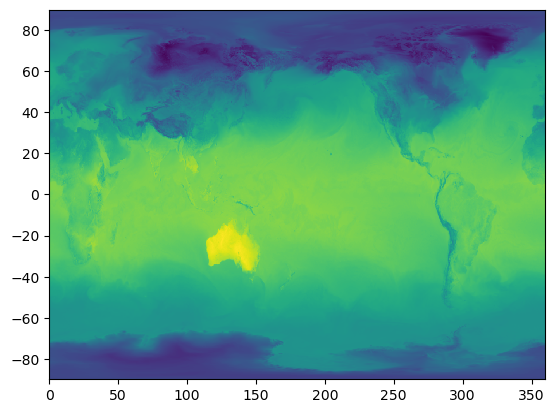

In [21]:
OURS_dataset = xr.open_dataset(conf['geo']['geo_file_nc'])
x_OURS = np.array(OURS_dataset['longitude'])
y_OURS = np.array(OURS_dataset['latitude'])
lon_OURS, lat_OURS = np.meshgrid(x_OURS, y_OURS)

plt.pcolormesh(lon_OURS, lat_OURS, test['t2m'][0, ...])